# Bankf of England spot Exchange rate from Euro to US Dollar (1975-2017)

In [13]:
import pandas as pd
import matplotlib.pylab as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import numpy as np


In [14]:
df_fx_data = pd.read_csv('BOE-XUDLERD.csv')
df_fx_data

,Date,Value
0,2017-11-09,0.8603
1,2017-11-08,0.8631
2,2017-11-07,0.8639
3,2017-11-06,0.8631
4,2017-11-03,0.8608
5,2017-11-02,0.8567
6,2017-11-01,0.8608
7,2017-10-31,0.8584
8,2017-10-30,0.8601
9,2017-10-27,0.8635


In [15]:
df_fx_data['Date'] = pd.to_datetime(df_fx_data['Date'])
indexed_df = df_fx_data.set_index('Date')
ts = indexed_df['Value']
indexed_df.head()

,Value
Date,
2017-11-09,0.8603
2017-11-08,0.8631
2017-11-07,0.8639
2017-11-06,0.8631
2017-11-03,0.8608


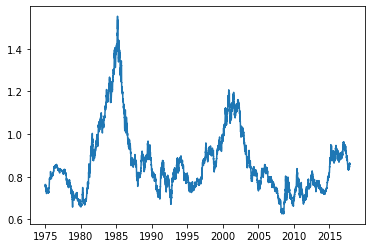

In [16]:
# visualize the raw data
plt.plot(ts)

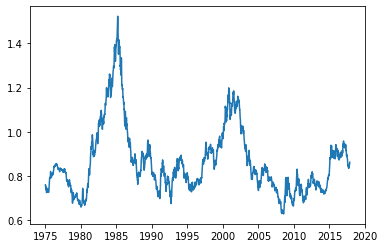

In [17]:
# resample data: we see too much variation so let's resample the data by week

ts_week = ts.resample('W').mean()
plt.plot(ts_week)

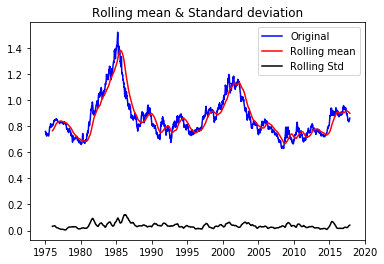

Results of the dickey -fuller test
Test statistics                  -2.076341
p-value                           0.254134
Lags used                         2.000000
Number of observations used    2234.000000
Critical value 1%                -3.433281
Critical value 5%                -2.862835
Critical value 10%               -2.567459
dtype: float64


In [18]:
# check for stationarity : dickey fuller test

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=52, center=False).mean()
    rolstd = timeseries.rolling(window=52, center=False).std()
    # visualise the rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title("Rolling mean & Standard deviation")
    plt.show(block=False)
    
    # perform the dickey fuller test
    print("Results of the dickey -fuller test")
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test statistics', 'p-value',
                                             'Lags used', 'Number of observations used'])
    for key, value in dftest[4].items():
        dfoutput['Critical value %s'%key] = value
    print(dfoutput)

test_stationarity(ts_week)


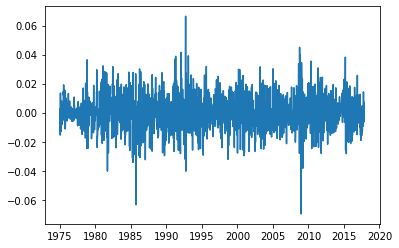

In [19]:
# timeseries is not stationrized, so let's stationarize it
# differencing
ts_week_log = np.log(ts_week)
ts_week_log_diff = ts_week_log - ts_week_log.shift()
plt.plot(ts_week_log_diff)

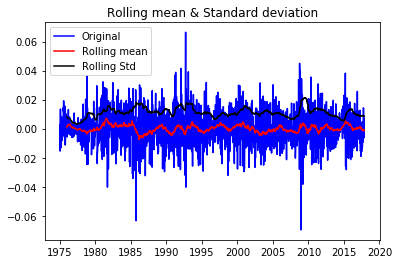

Results of the dickey -fuller test
Test statistics                 -36.590004
p-value                           0.000000
Lags used                         0.000000
Number of observations used    2235.000000
Critical value 1%                -3.433279
Critical value 5%                -2.862834
Critical value 10%               -2.567459
dtype: float64


In [20]:
ts_week_log_diff.dropna(inplace=True)
test_stationarity(ts_week_log_diff)

Text(0.5, 1.0, 'Auto correlation function')

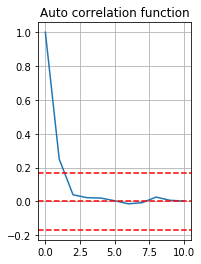

In [21]:
# now timeseries is stationarized so we can apply the ARIMA model
# ACF and PACF

lag_acf = acf(ts_week_log_diff, nlags=10)
lag_pacf = pacf(ts_week_log_diff, nlags=10, method='ols')

# plot for ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color="red")
plt.axhline(y=-7.96/np.sqrt(len(ts_week_log_diff)), linestyle='--', color='red')
plt.axhline(y=7.96/np.sqrt(len(ts_week_log_diff)), linestyle='--', color='red')
plt.grid(True)
plt.title('Auto correlation function')


Text(0.5, 1.0, 'Partial Auto correlation function')

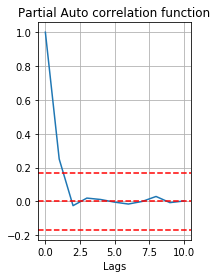

In [22]:
# plot PACF
plt.subplot(121)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color="red")
plt.axhline(y=-7.96/np.sqrt(len(ts_week_log_diff)), linestyle='--', color='red')
plt.axhline(y=7.96/np.sqrt(len(ts_week_log_diff)), linestyle='--', color='red')
plt.grid(True)
plt.xlabel("Lags")
plt.title('Partial Auto correlation function')



Text(0.5, 1.0, 'RSS: %.2f')

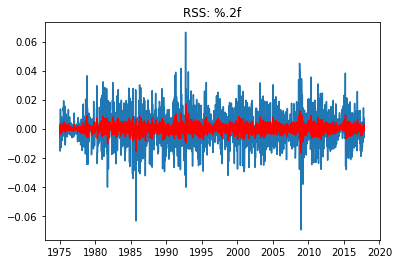

In [23]:
# plotting the ARIMA model
model =ARIMA(ts_week_log, order=(2, 1, 1))
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_week_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.2f')


                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                 2236
Model:                 ARIMA(2, 1, 1)   Log Likelihood                6870.601
Method:                       css-mle   S.D. of innovations              0.011
Date:                Sat, 21 Sep 2019   AIC                         -13731.202
Time:                        16:27:01   BIC                         -13702.640
Sample:                    01-12-1975   HQIC                        -13720.773
                         - 11-12-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           5.51e-05      0.000      0.178      0.859      -0.001       0.001
ar.L1.D.Value    -0.0901      0.487     -0.185      0.853      -1.044       0.864
ar.L2.D.Value     0.0602      0.128     

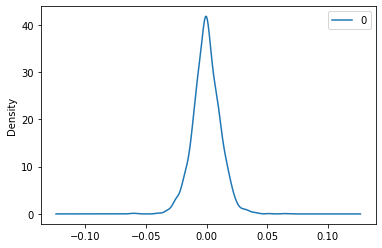

In [24]:
print(results_ARIMA.summary())

# plot residual errors
residuals = pd.DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())